<a href="https://colab.research.google.com/github/weilainicolas/Deep-Learning/blob/master/Mnist_adam_Weight_Decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.basics import*

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving mnist.pkl.gz to mnist.pkl.gz
User uploaded file "mnist.pkl.gz" with length 16168813 bytes


```
1 Download data and extract train and valid

2 convert x_train, y_train, x_valid, y_valid to tensor

3 create train_ds, valid_ds Dataset from #2

4 create databunch from #3
```




In [0]:
with gzip.open('/content/mnist.pkl.gz','rb') as f:
  ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding='latin-1')

In [0]:
x_train,y_train,x_valid,y_valid=map(torch.tensor,(x_train,y_train,x_valid,y_valid))

In [0]:
train_ds=TensorDataset(x_train,y_train)
valid_ds=TensorDataset(x_valid,y_valid)
data=DataBunch.create(train_ds,valid_ds,bs=64)

```
Create a model and define the calculation 
here is a 3 layers model, 2 parameter 1 active 
```

In [0]:
class log_m(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1=nn.Linear(784,200,bias=True)
    self.lin2=nn.Linear(200,10,bias=True)
  def forward(self,a):
    x=self.lin1(a)
    x=F.relu(x)
    return self.lin2(x)

In [0]:
model=log_m().cuda()

```
#1 define loss function, here we are predicting categorical data. thus, use cross entropy. 
#2 define OPT function. Try adam instead of SGD this time.

```

In [0]:
loss_func=nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
  wd=1e-5
  w=0.
  for p in model.parameters(): w+= (p**2).sum()
  opt=optim.Adam(model.parameters(),lr,weight_decay=wd)
  y_hat=model(x)
  loss=loss_func(y_hat,y)+wd*w
  loss.backward()
  opt.step()
  opt.zero_grad()
  return loss.item()

In [0]:
losses=[update(x,y,1e-3) for x,y in data.train_dl]

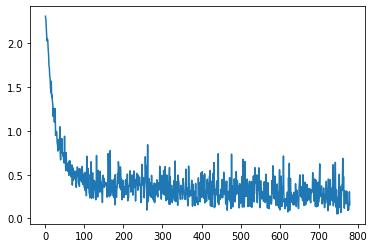

In [46]:
plt.plot(losses)

In [0]:
learn=Learner(data,log_m(), loss_func=loss_func, metrics=accuracy)

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


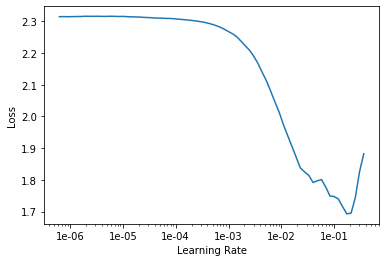

In [51]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(1,5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.136540,0.111023,0.968500,00:04
